# Synopsis
ISS_tools.visual is a Python module for visualizing and analyzing protein structural alignments, especially from DALI. Input data can be generated by ISS_ProtSci or standalone DALI. Standalone DALI output should be post-processed with ISS_tools.process.

## Classes 
### Class pfam
Loads reference classification data, such as from the current Pfam release (Pfam_38.0 in July 2025).

### Class DALIFrame
Wraps a DALI alignment results DataFrame and provides high-level methods for data handling and visualization:

- add_TRUE - marks members of selected clan in 'TRUE' column 
  
- grouplabel() – declutters subject labels

- subset() – filters rows based on score or length thresholds

- scatter() – creates a static scatterplot using Matplotlib

- iscatter() – creates an interactive scatterplot using Plotly

- write_FASTA - outputs FASTA format for sequence tools

### Class msa
Visualizes multiple sequence alignments (MSAs), where each row is a string of equal length (e.g., DSSP or residue codes):

- heatmap() – render a colored heatmap of the alignment with optional color, marker and size attributes

- logo() – plot a sequence logo showing per-column conservation

## Functions
- diff_df(df1, df2) = compares two alignment result sets and visualizes their overlap for binary classification evaluation.
- write_FASTA() - output sequences for downstream analysis by sequence tools



# Demo 1: PRELI Domain Comparison Against AFDB2
This demo illustrates the use of ISS_tools.visual on structural alignment data generated by ISS_ProtSci using default parameters. The query structure corresponds to a PRELI domain, a Pfam family classified within the Bet v1-like clan.

ISS_ProtSci automatically identifies the nearest matching clan from the database. In this case, it correctly assigns the query to CL0209.

By plotting the data distribution in the (Z-score, alignment length) space, we observe a clear separation between clan members and unrelated background structures. While this plot represents a comparison of radial distributions, the inclusion of known positives (true clan members) enables effective demarcation of the clan boundary.

After filtering out the background alignments, heatmaps reveal full structural coverage of the query by clan members. Notably, two novel families also exhibit complete coverage and are interspersed with members of CL0209—suggesting they may justifiably be included in the clan.

The sequence profile highlights strong conservation of hydrophobic residues at key positions. This pattern implies a non-enzymatic function, aligning with the known or proposed role of Bet v1-like clan members in lipid binding.

## Prepare environment

In [39]:
%pip install -e .. -q
%pip install -e "..[visualization]" -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [40]:
import sys
import os
import pandas as pd
# Add the repo root to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
# ISS_tools
import ISS_tools.visual  # read_tsv, diff_df, msa, read_dali_tsv, write_FASTA
import ISS_tools.Pfam    # Pfam
import ISS_tools.helpers # fit_line
# Reference classification (Pfam database)
pf=ISS_tools.Pfam.Pfam('../pfamdata')
pf.load_TRUE('../pfamdata/DaliDigest.clan_hmmer_tc.tsv')

# User inputs

In [41]:
# ISS_ProtSci outputs
tsvfile='../demo_data/PRELI.AFDB2.pf.tsv' 
TRUE_CLAN_DALI_tsv='../demo_data/PRELI.CL0209.TRUE.dali.tsv'

## Load Query 
ISS_ProtSci search results are loaded to a DALIFrame object, which is a Pandas DataFrame with custom methods. 

The grouplabel method keeps the k most frequent classes in labelin and pools the rest into class 'other', writing these to labelout.

In [42]:
# load input tsvfile to a DALIFrame object with custom methods
df=ISS_tools.visual.read_tsv(tsvfile)
# reduce number of labels
df.grouplabel(k=5,labelin='pfam',labelout='family')
df.grouplabel(k=5,labelin='clan',labelout='superfamily')
#df.dtypes

assign PF04707
assign PF16016
assign PF10698
assign unassigned
assign PF02121
assign CL0209
assign unassigned
assign PF09366
assign PF09348
assign PF19444


# Distribution of data points in (z-score, ali-length) plane

In [43]:
# matplotlib version
df.iscatter(color='seq-identity',marker='superfamily',size='sbjct-coverage')

The closest hits are in clan CL0209, so lets focus on how the members of that clan are distributed.

In [44]:
CLAN='CL0209'
df.add_TRUE(CLAN, pf.TRUE_df)

In [45]:
df.iscatter(color='TRUE',title='Ground truth',size='seq-identity')

There are many clan members which have quite low Z-scores when compared to the Query structure. 

# Filtering
We fit a line through the neck region using the helper function fit_line, and apply the df.subset() method to filter the data accordingly. The diff_df function is then used to evaluate the effectiveness of the cutoff.

y > -5.0*x+160.0 selected 1290 data points.


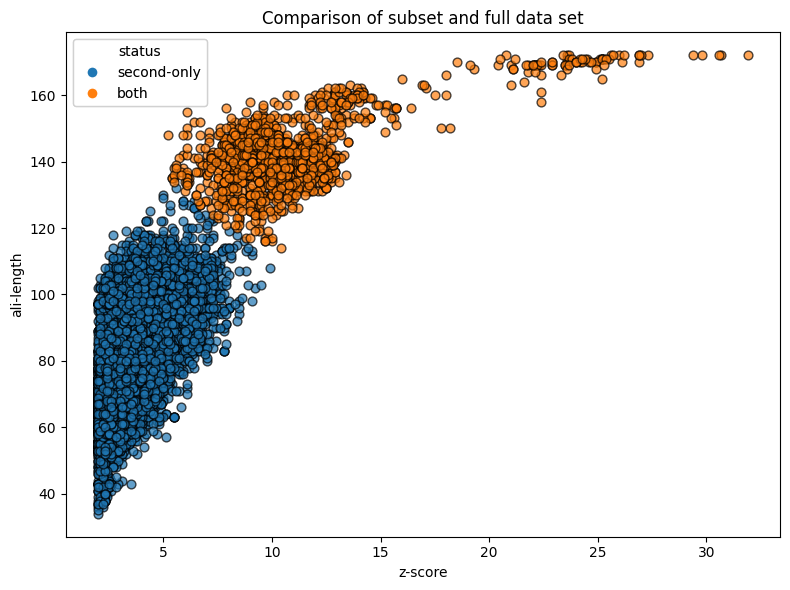

In [46]:
# line passing through (0,160) and (16,80): y = -5*x+160
slope,xcross=ISS_tools.helpers.fit_line([0,160],[16,80])
# subset_df = df.subset((df['dssp-order'] > '00100') & (df['dssp-order']< '00500'))  
subset_df = df.subset((df['ali-length'] > slope*df['z-score']+xcross))
print(f'y > {slope}*x+{xcross} selected {subset_df.shape[0]} data points.')
# verify filtering result visually
x = ISS_tools.visual.diff_df(subset_df,df,None,None,title='Comparison of subset and full data set',plotfun='scatter')

# Structural coherence of DALI hits
We now use the msa module to visualize the stacked alignments of the filtered subset. The secondary structure elements are consistently aligned across the dataset. There is no strong pattern of sequence conservation, but a general preference for hydrophobic residues is observed.

(1290, 39) <class 'ISS_tools.visual.DALIFrame'>


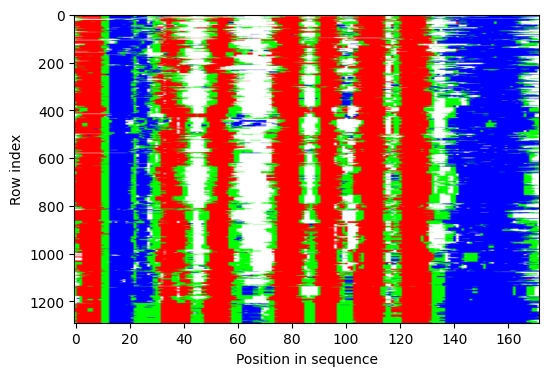

In [47]:
subset_df = subset_df.sort_values(by="dssp-order", ascending=False)
print(subset_df.shape, type(subset_df))
a=ISS_tools.visual.msa(subset_df,'sequ-pileup')
b=ISS_tools.visual.msa(subset_df,'dssp-pileup')
#a.heatmap()
b.heatmap()

Color scheme: alpha helix - blue; beta strand - red; loop - green; gap (deletion relative to query) - white.

In [ ]:
# Generating logos for large multiple sequence alignments can be slow.
a.logo()
#b.logo()

## Novel findings in the subset
The filtered subset is enriched for members of clan CL0209—but is there anything else of interest?

We use the 'superfamily' column to indicate Pfam assignments. These assignments are based on domain fragments and capture many, though not all, instances of a given Pfam family. In contrast, the 'TRUE' column represents the full set of clan members as defined by Pfam.

Marker style in the plot indicates the source of the clan annotation, while color encodes superfamily identity. Green and blue squares represent known CL0209 members. Notably, red and cyan circles highlight two novel families that are interspersed with known members of CL0209—suggesting they may also belong to this clan.

In [30]:
subset_df.iscatter(color='superfamily',marker='TRUE',title='',size=None)

### What Pfam families are known members of the CLAN?

In [31]:
CLAN='CL0209'
pf.pfam_data_df[pf.pfam_data_df['CL']==CLAN][['AC','CL','DE','ML']].sort_values(by=['AC'])

,AC,CL,DE,ML
1791,PF00407,CL0209,Pathogenesis-related protein Bet v 1 family,151
19723,PF00848,CL0209,Ring hydroxylating alpha subunit (catalytic do...,208
21324,PF01852,CL0209,START domain,207
13793,PF02121,CL0209,Phosphatidylinositol transfer protein,246
5248,PF02713,CL0209,Domain of unknown function DUF220,73
18361,PF03364,CL0209,Polyketide cyclase / dehydrase and lipid trans...,126
18627,PF04707,CL0209,PRELI-like family,157
3435,PF06240,CL0209,Carbon monoxide dehydrogenase subunit G (CoxG),140
14395,PF06804,CL0209,NlpB/DapX lipoprotein,323
595,PF08327,CL0209,Activator of Hsp90 ATPase homolog 1-like protein,125


Pfam profile lengths (ML) vary considerably. ISS_ProtSci finds matches with high coverage of the Query structure (i.e. long structural alignments).      

### What are the novel findings?
Here, we remove the known clan members from the filtered subset.

In [32]:
novel_df = subset_df.subset(subset_df['TRUE']=='unassigned')
print(novel_df.shape,type(novel_df))
pd.set_option('display.max_colwidth', None)

(125, 39) <class 'ISS_tools.visual.DALIFrame'>


### Domain composition of novel proteins
The Pfam database is bundled with the distribution package, making its data readily accessible within ISS_tools. Here, we create two new columns—pfamlist and clanlist—which contain all Pfam domains present in the full-length protein sequences.

It's important to note that many of the novel proteins are large and multidomain. As a result, the listed domains may reside outside the region aligned to the query structure.

In [33]:
novel_all_pf = pf.pfam_composition(novel_df)[['sbjct','pfamlist','clanlist','z-score','ali-length','sbjct-length','description','species']]
print('\nFrequent Pfam family compositions\n',novel_all_pf['pfamlist'].value_counts()[:10])
#print('\nFrequent Pfam clan compositions\n',novel_all_pf['clanlist'].value_counts()[:10])


Frequent Pfam family compositions
 pfamlist
[]                    60
[PF07757]             27
[PF09366]             18
[PF09348]              8
[PF02893]              4
[PF08338, PF01370]     2
[PF00169]              1
[PF07021, PF07757]     1
[PF00168]              1
[PF01370]              1
Name: count, dtype: int64


We recognize PF09366 and PF09348 from the previous scatterplot. They are both domains of unknown function.

PF07757 is new. It is annotated as a methyltransferase, but this domain is located in different part of the protein compared to the PRELI-like domain. This can be verified for example using the pairwise alignment and Pfam cartoon options of the DALI web server.

In [34]:
pf.pfam_data_df[pf.pfam_data_df['AC'].isin(['PF07757','PF09366','PF09348'])][['AC','CL','DE']]

,AC,CL,DE
505,PF07757,CL0063,Predicted AdoMet-dependent methyltransferase
5112,PF09348,NaN,Domain of unknown function (DUF1990)
5116,PF09366,NaN,Protein of unknown function (DUF1997)


Here, we print a comprehensive list of all the novel proteins in the filtered subset that are not members of CL0209. Some proteins have descriptions indicating CL02909 membership though they are assigned as members in the Pfam database. 

ISS_ProtSci outputs are annotated with Uniprot metadata (such as species), because it searchs AlphaFold Database v2, which is derived from Uniprot proteins, so there is a direct link between Dali identifiers for each structural model and Uniprot accession numbers. Uniprot metadata is not available for PDB or custom database search results.

In [35]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

## FASTA output for sequence tools

In [36]:
novel_df.write_FASTA(seq_col='sbjct-sequence',outfile='full.fasta')
novel_df.write_FASTA(seq_col='sequ-pileup',outfile='frag.fasta')

# Evaluation: comparing two sets of DALI hits
So far, we’ve evaluated true positives using Pfam annotations. When a comprehensive reference classification is available, it also allows us to identify false negatives.

In this case, the filtered subset includes 155 high-scoring hits not present in Pfam, suggesting potential novel members. Conversely, 125 Pfam-annotated instances with low scores were excluded by the filter. Notably, there are very few false negatives among high-scoring hits, which can be confirmed by zooming in on the Plotly scatterplot.

Read 1289 rows with 14 columns from ../demo_data/PRELI.CL0209.TRUE.dali.tsv
status
both           1148
second-only     142
first-only      141
Name: count, dtype: int64


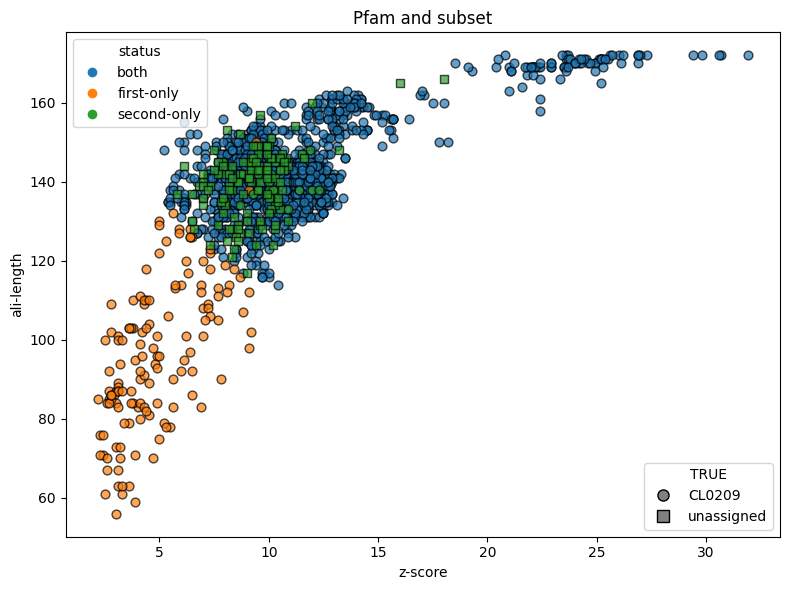

In [37]:
# ordinary Pandas DataFrames
TRUE_dali_df = ISS_tools.visual.read_dali_tsv(TRUE_CLAN_DALI_tsv)
CLAN='CL0209'
x = ISS_tools.visual.diff_df(TRUE_dali_df,subset_df,CLAN,pf.TRUE_df,title='Pfam and subset',plotfun='scatter')

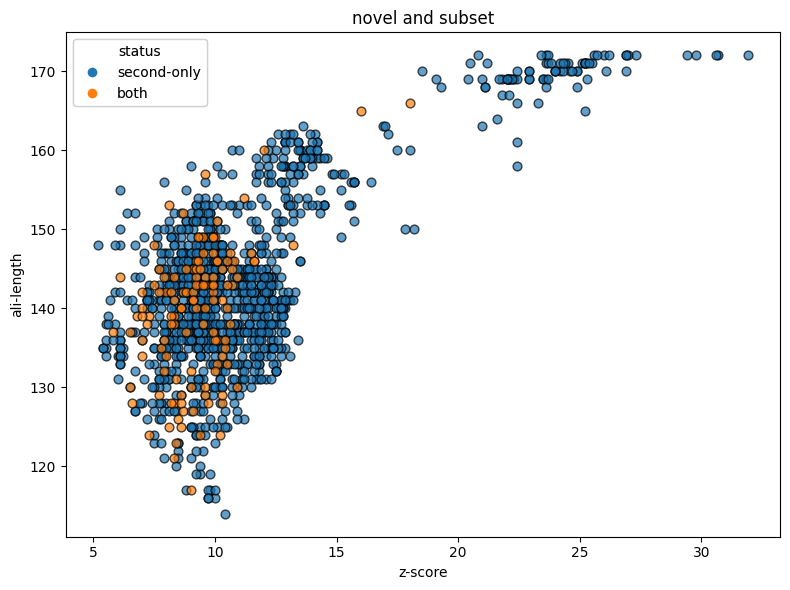

In [38]:
y = ISS_tools.visual.diff_df(novel_df,subset_df,None,None,plotfun='scatter',title='novel and subset')

# Save df to file 